In [39]:
# Install the missing package for imbalanced-learn (provides imblearn)
%pip install imbalanced-learn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
from sklearn.utils import resample
import warnings
warnings.filterwarnings('ignore')

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [40]:
df = pd.read_csv('C:\\Users\\sureh\\Downloads\\archive (2)\\Churn_Modelling.csv')

print("Dataset Shape:", df.shape)
print("\nFirst few rows:")
print(df.head())

Dataset Shape: (10000, 14)

First few rows:
   RowNumber  CustomerId   Surname  CreditScore Geography  Gender  Age  \
0          1    15634602  Hargrave          619    France  Female   42   
1          2    15647311      Hill          608     Spain  Female   41   
2          3    15619304      Onio          502    France  Female   42   
3          4    15701354      Boni          699    France  Female   39   
4          5    15737888  Mitchell          850     Spain  Female   43   

   Tenure    Balance  NumOfProducts  HasCrCard  IsActiveMember  \
0       2       0.00              1          1               1   
1       1   83807.86              1          0               1   
2       8  159660.80              3          1               0   
3       1       0.00              2          0               0   
4       2  125510.82              1          1               1   

   EstimatedSalary  Exited  
0        101348.88       1  
1        112542.58       0  
2        113931.57       1 

In [41]:
# Exploratory Data Analysis
print("Dataset Info:")
print(df.info())
print("\nMissing Values:")
print(df.isnull().sum())
print("\nDataset Description:")
print(df.describe())

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB
None

Missing Values:
RowNumber          0
CustomerId         0
Surname         

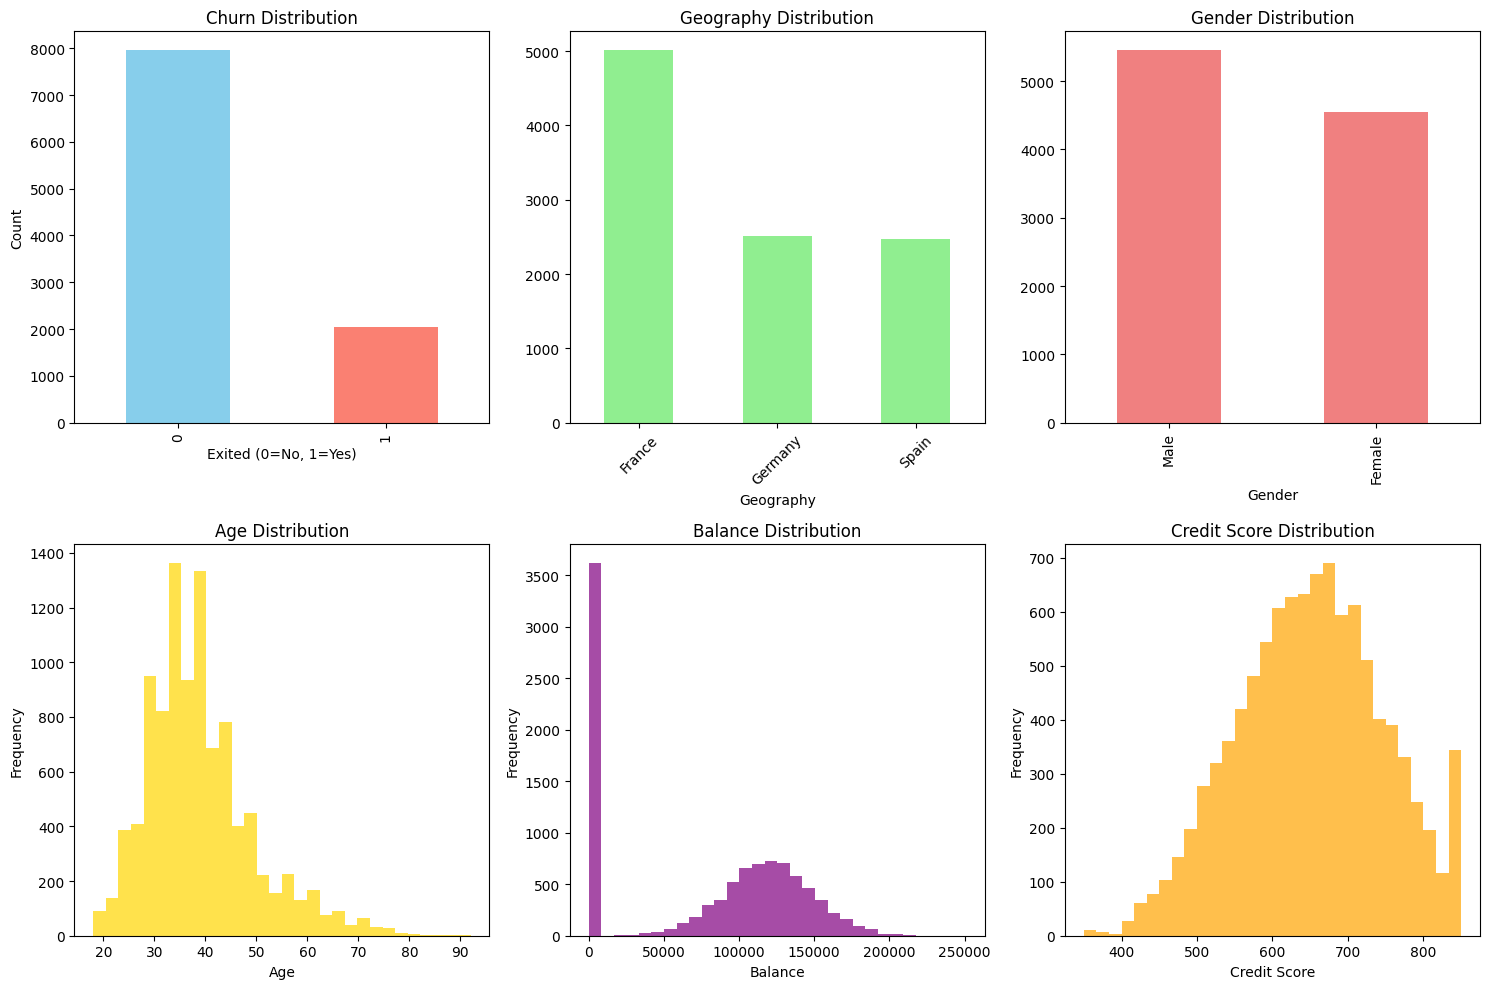

In [42]:
# Visualize the target variable distribution
plt.figure(figsize=(15, 10))

plt.subplot(2, 3, 1)
df['Exited'].value_counts().plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Churn Distribution')
plt.xlabel('Exited (0=No, 1=Yes)')
plt.ylabel('Count')

plt.subplot(2, 3, 2)
df['Geography'].value_counts().plot(kind='bar', color='lightgreen')
plt.title('Geography Distribution')
plt.xticks(rotation=45)

plt.subplot(2, 3, 3)
df['Gender'].value_counts().plot(kind='bar', color='lightcoral')
plt.title('Gender Distribution')

plt.subplot(2, 3, 4)
plt.hist(df['Age'], bins=30, color='gold', alpha=0.7)
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Frequency')

plt.subplot(2, 3, 5)
plt.hist(df['Balance'], bins=30, color='purple', alpha=0.7)
plt.title('Balance Distribution')
plt.xlabel('Balance')
plt.ylabel('Frequency')

plt.subplot(2, 3, 6)
plt.hist(df['CreditScore'], bins=30, color='orange', alpha=0.7)
plt.title('Credit Score Distribution')
plt.xlabel('Credit Score')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

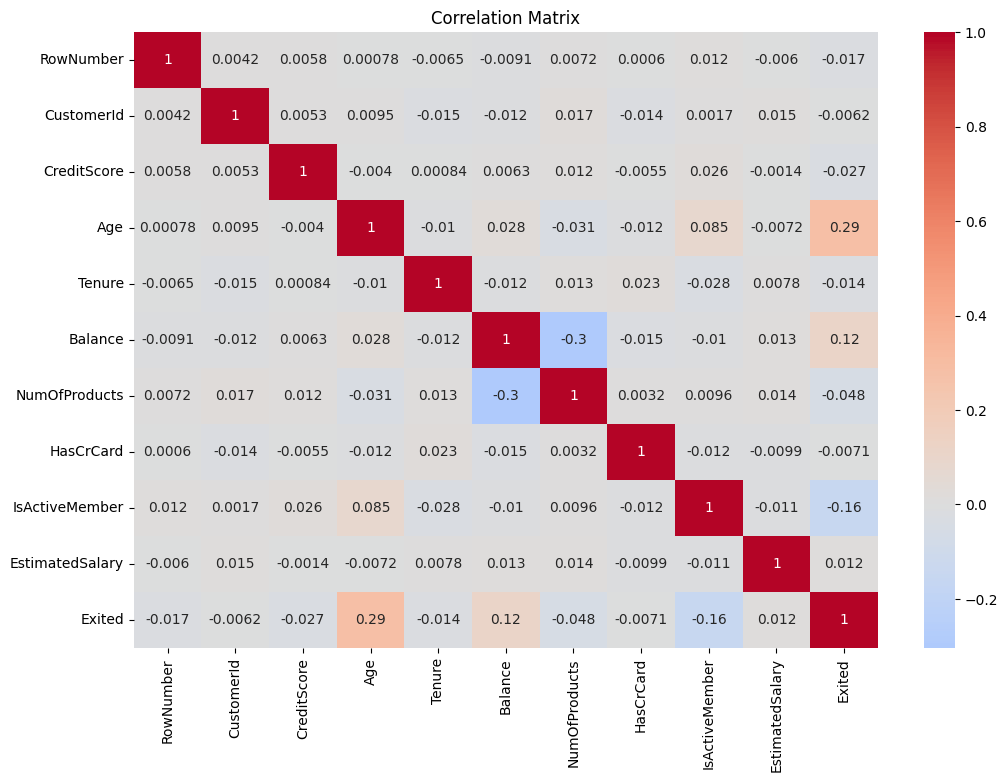

In [43]:
# Correlation analysis
plt.figure(figsize=(12, 8))
numeric_df = df.select_dtypes(include=[np.number])
correlation_matrix = numeric_df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix')
plt.show()

In [44]:
# Data Preprocessing
def preprocess_data(df):
    # Drop unnecessary columns
    df_clean = df.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1)
    
    # Encode categorical variables
    le = LabelEncoder()
    df_clean['Gender'] = le.fit_transform(df_clean['Gender'])
    
    # One-hot encoding for Geography
    df_clean = pd.get_dummies(df_clean, columns=['Geography'], prefix='Geo')
    
    return df_clean

# Preprocess the data
df_processed = preprocess_data(df)

print("Processed Data Shape:", df_processed.shape)
print("\nProcessed Data Columns:")
print(df_processed.columns)

Processed Data Shape: (10000, 13)

Processed Data Columns:
Index(['CreditScore', 'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts',
       'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'Exited',
       'Geo_France', 'Geo_Germany', 'Geo_Spain'],
      dtype='object')


In [45]:
from sklearn.utils import resample

# Handle class imbalance
def handle_imbalance(df, target_col):
    # Separate majority and minority classes
    df_majority = df[df[target_col] == 0]
    df_minority = df[df[target_col] == 1]
    
    # Upsample minority class
    df_minority_upsampled = resample(df_minority,
                                   replace=True,
                                   n_samples=len(df_majority),
                                   random_state=42)
    
    # Combine majority class with upsampled minority class
    df_balanced = pd.concat([df_majority, df_minority_upsampled])
    
    return df_balanced

# Check class distribution before balancing
print("Original class distribution:")
print(df_processed['Exited'].value_counts())

# Balance the dataset
df_balanced = handle_imbalance(df_processed, 'Exited')

print("\nBalanced class distribution:")
print(df_balanced['Exited'].value_counts())

Original class distribution:
Exited
0    7963
1    2037
Name: count, dtype: int64

Balanced class distribution:
Exited
0    7963
1    7963
Name: count, dtype: int64


In [46]:
# Prepare features and target
X = df_balanced.drop('Exited', axis=1)
y = df_balanced['Exited']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Training set shape:", X_train_scaled.shape)
print("Testing set shape:", X_test_scaled.shape)

Training set shape: (12740, 12)
Testing set shape: (3186, 12)


In [47]:
# Initialize models
models = {
    'Logistic Regression': LogisticRegression(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'SVM': SVC(probability=True, random_state=42)
}

# Train and evaluate models
results = {}

for name, model in models.items():
    print(f"\nTraining {name}...")
    
    # Train model
    if name == 'SVM':
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
        y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    # Calculate metrics
    accuracy = model.score(X_test if name != 'SVM' else X_test_scaled, y_test)
    auc_score = roc_auc_score(y_test, y_pred_proba)
    
    results[name] = {
        'model': model,
        'accuracy': accuracy,
        'auc': auc_score,
        'predictions': y_pred,
        'probabilities': y_pred_proba
    }
    
    print(f"{name} Accuracy: {accuracy:.4f}")
    print(f"{name} AUC: {auc_score:.4f}")


Training Logistic Regression...


Logistic Regression Accuracy: 0.6682
Logistic Regression AUC: 0.7250

Training Random Forest...
Random Forest Accuracy: 0.9551
Random Forest AUC: 0.9940

Training Gradient Boosting...
Gradient Boosting Accuracy: 0.7903
Gradient Boosting AUC: 0.8845

Training SVM...
SVM Accuracy: 0.8023
SVM AUC: 0.8874


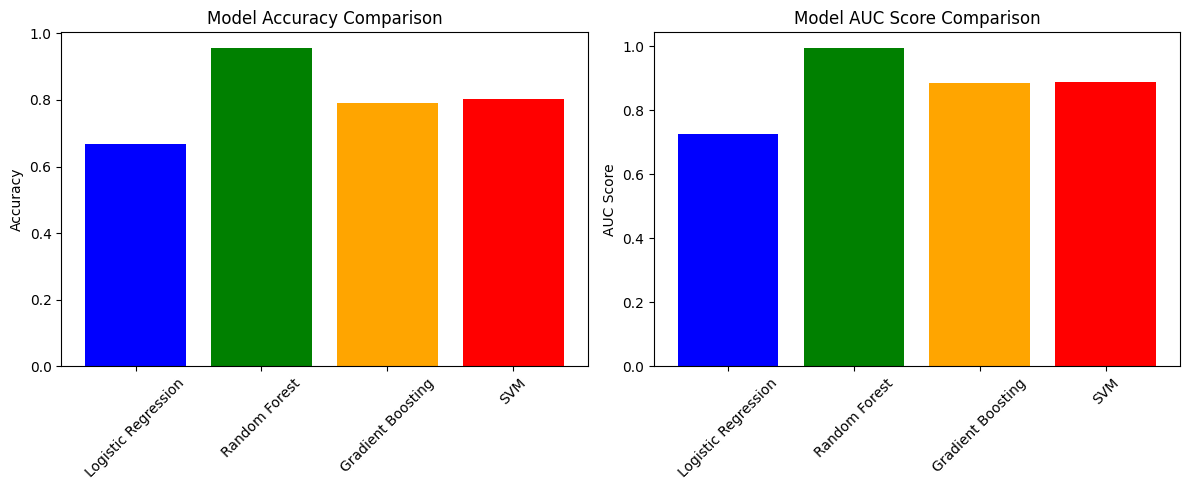

In [48]:
# Compare model performance
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
model_names = list(results.keys())
accuracies = [results[name]['accuracy'] for name in model_names]
plt.bar(model_names, accuracies, color=['blue', 'green', 'orange', 'red'])
plt.title('Model Accuracy Comparison')
plt.xticks(rotation=45)
plt.ylabel('Accuracy')

plt.subplot(1, 2, 2)
auc_scores = [results[name]['auc'] for name in model_names]
plt.bar(model_names, auc_scores, color=['blue', 'green', 'orange', 'red'])
plt.title('Model AUC Score Comparison')
plt.xticks(rotation=45)
plt.ylabel('AUC Score')

plt.tight_layout()
plt.show()

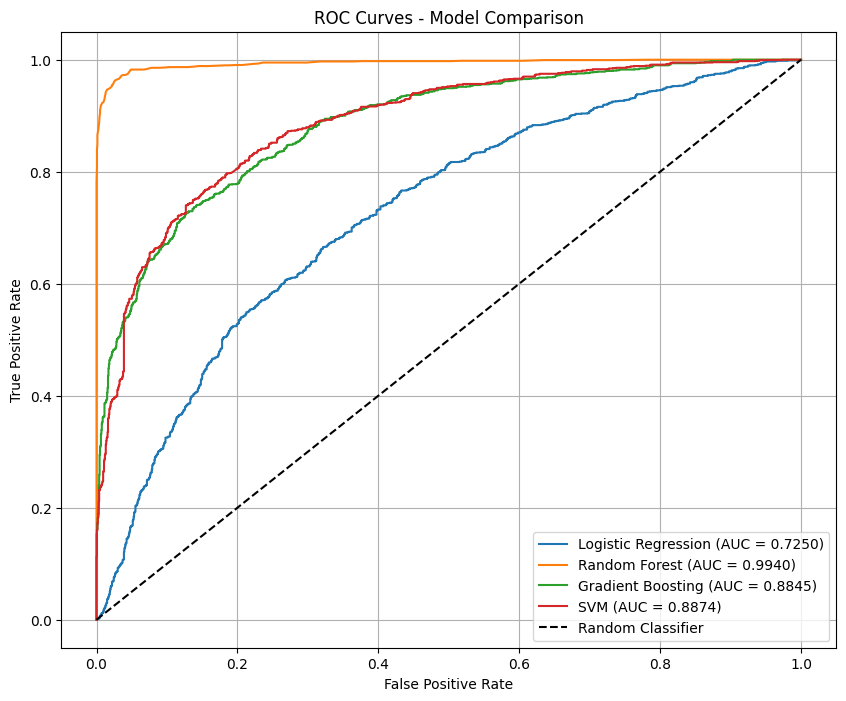

In [49]:
# ROC Curves for all models
plt.figure(figsize=(10, 8))

for name, result in results.items():
    fpr, tpr, _ = roc_curve(y_test, result['probabilities'])
    plt.plot(fpr, tpr, label=f'{name} (AUC = {result["auc"]:.4f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves - Model Comparison')
plt.legend()
plt.grid(True)
plt.show()

Best Model: Random Forest
Best AUC Score: 0.9940

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.93      0.95      1593
           1       0.93      0.98      0.96      1593

    accuracy                           0.96      3186
   macro avg       0.96      0.96      0.96      3186
weighted avg       0.96      0.96      0.96      3186


Confusion Matrix:


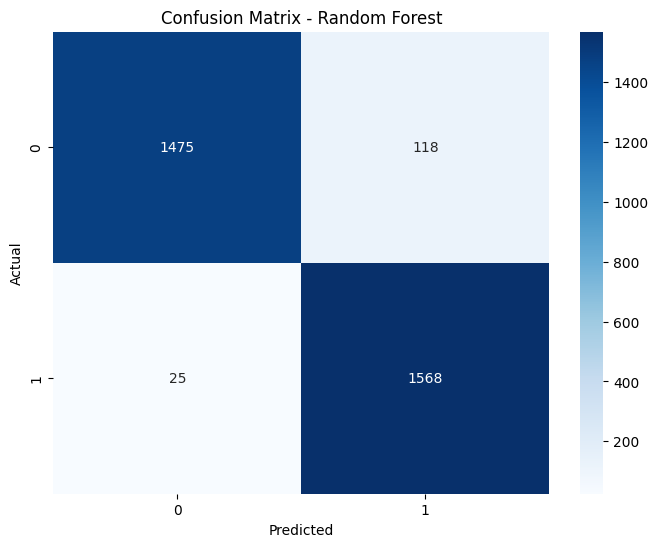

In [50]:
# Detailed evaluation of the best model
best_model_name = max(results, key=lambda x: results[x]['auc'])
best_model = results[best_model_name]['model']
best_predictions = results[best_model_name]['predictions']

print(f"Best Model: {best_model_name}")
print(f"Best AUC Score: {results[best_model_name]['auc']:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, best_predictions))

print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, best_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title(f'Confusion Matrix - {best_model_name}')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

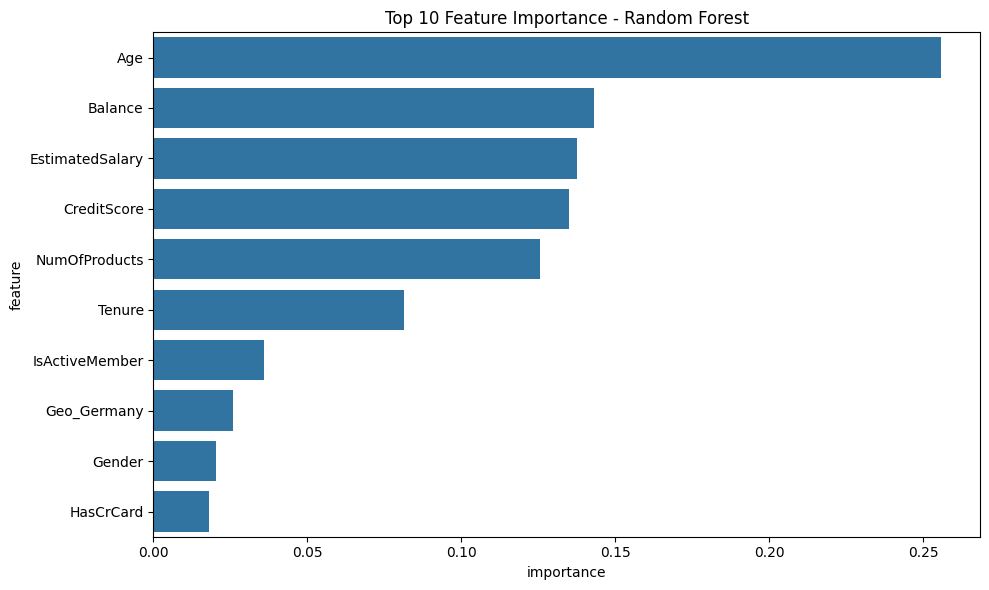

Top 10 Most Important Features:
            feature  importance
2               Age    0.255614
4           Balance    0.143167
8   EstimatedSalary    0.137672
0       CreditScore    0.134788
5     NumOfProducts    0.125527
3            Tenure    0.081215
7    IsActiveMember    0.035894
10      Geo_Germany    0.025932
1            Gender    0.020452
6         HasCrCard    0.018015


In [51]:
# Feature Importance (for tree-based models)
if hasattr(best_model, 'feature_importances_'):
    feature_importance = pd.DataFrame({
        'feature': X.columns,
        'importance': best_model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    plt.figure(figsize=(10, 6))
    sns.barplot(data=feature_importance.head(10), x='importance', y='feature')
    plt.title(f'Top 10 Feature Importance - {best_model_name}')
    plt.tight_layout()
    plt.show()
    
    print("Top 10 Most Important Features:")
    print(feature_importance.head(10))

In [56]:
# Hyperparameter Tuning for the best model
if best_model_name == 'Random Forest':
    param_grid = {
        'n_estimators': [100, 200, 300],
        'max_depth': [10, 20, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }
    
    grid_search = GridSearchCV(
        RandomForestClassifier(random_state=42),
        param_grid,
        cv=5,
        scoring='roc_auc',
        n_jobs=-1
    )
    
    grid_search.fit(X_train, y_train)
    
    print("Best parameters:", grid_search.best_params_)
    print("Best cross-validation score: {:.4f}".format(grid_search.best_score_))

Best parameters: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
Best cross-validation score: 0.9866


In [58]:
from sklearn.metrics import accuracy_score

# Final Model Evaluation
final_predictions = best_model.predict(X_test)
final_probabilities = best_model.predict_proba(X_test)[:, 1]

print("Final Model Performance:")
print(f"Accuracy: {accuracy_score(y_test, final_predictions):.4f}")
print(f"AUC Score: {roc_auc_score(y_test, final_probabilities):.4f}")
print("\nFinal Classification Report:")
print(classification_report(y_test, final_predictions))

Final Model Performance:
Accuracy: 0.9551
AUC Score: 0.9940

Final Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.93      0.95      1593
           1       0.93      0.98      0.96      1593

    accuracy                           0.96      3186
   macro avg       0.96      0.96      0.96      3186
weighted avg       0.96      0.96      0.96      3186



In [59]:
# Create a function for predicting churn on new data
def predict_churn(new_customer_data, model, scaler=None, features=None):
    """
    Predict churn probability for new customer data
    """
    # Ensure the data has the same features as training data
    if features is not None:
        new_customer_data = new_customer_data[features]
    
    # Make prediction
    churn_probability = model.predict_proba(new_customer_data)[0, 1]
    churn_prediction = model.predict(new_customer_data)[0]
    
    return churn_prediction, churn_probability

# Example usage with sample data
sample_customer = X_test.iloc[0:1]  # Take first test sample
prediction, probability = predict_churn(sample_customer, best_model)

print(f"Sample Customer Churn Prediction: {'Yes' if prediction == 1 else 'No'}")
print(f"Churn Probability: {probability:.4f}")
print(f"Actual Value: {y_test.iloc[0]}")

Sample Customer Churn Prediction: No
Churn Probability: 0.2700
Actual Value: 0
